In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
class GaussianMixture:
    def __init__(self, alpha, mu, sigma, epsilon=1e-3, max_iter=1000):
        self.alpha = np.array(alpha).reshape(-1, 1)
        self.mu = np.array(mu) #(2,2)
        self.sigma = np.array(sigma) #(2,2)
        self.epsilon = epsilon
        self.max_iter = max_iter
                
        
    def fit(self, x):
        N, D = x.shape
        k = len(self.alpha)
        cov_maxtric = []
        for i in range(k):
            cov_maxtric.append(np.diag(self.sigma[i]))
            
        cov_maxtric = np.array(cov_maxtric)
       
        for i in range(self.max_iter):
            # E step
            density = []
            for i in range(k):
                density_k = self.alpha[i] * multivariate_normal(self.mu[i], cov_maxtric[i]).pdf(x).reshape(1, -1)
                density.append(density_k)
                
            density = np.array(density)  
            density = np.reshape(density,(-1, N))  #将三维(2, 1, 600) 变为 二维（2， 600）
            gamma = (density / (np.sum(density, axis=0)).reshape(1, -1))      #(2, 600) 每个样本属于k类的后验概率 

            mu_last = self.mu
            sigma_last = self.sigma
            # M step
            nk = np.sum(gamma, axis=1).reshape(-1, 1)  #(2, 1)  属于第k类的点的数量
            self.mu = np.array(np.dot(gamma, x) / nk)
            for i in range(k):
                top = np.dot(gamma,  np.power((x - self.mu[i]), 2))
                sigma_new = ((top / nk)[i]).reshape(1, -1)[0]
                self.sigma[i] = sigma_new
            
            self.alpha = nk / N
           
            if ((abs(mu - mu_last)).sum() < self.epsilon and (abs(sigma - sigma_last)).sum() < self.epsilon):
                break
                
                
    def get_params(self):
        return self.alpha, self.mu, self.sigma
       


In [3]:
# 随机生成两个二维的高斯分布
np.random.seed(0)
mu_true = [[1.0, 1.0], [4.0, 4.0]]
sigma_true = [[0.2, 0.2], [2.0, 2.0]]

data1 = np.random.multivariate_normal(mu_true[0], np.diag(sigma_true[0]), 300)
data2 = np.random.multivariate_normal(mu_true[1], np.diag(sigma_true[1]), 300)
data = np.vstack((data1, data2))
# y = np.array([True] * 300 + [False] * 300)
# ---------
# 训练
n, d = data.shape
mu1 = data.min(axis=0)
mu2 = data.max(axis=0)

mu = [mu1, mu2]
sigma = [[1.0,1.0], [3.0,3.0]]

g = GaussianMixture(alpha=[0.5, 0.5], mu=mu, sigma=sigma)
g.fit(data)

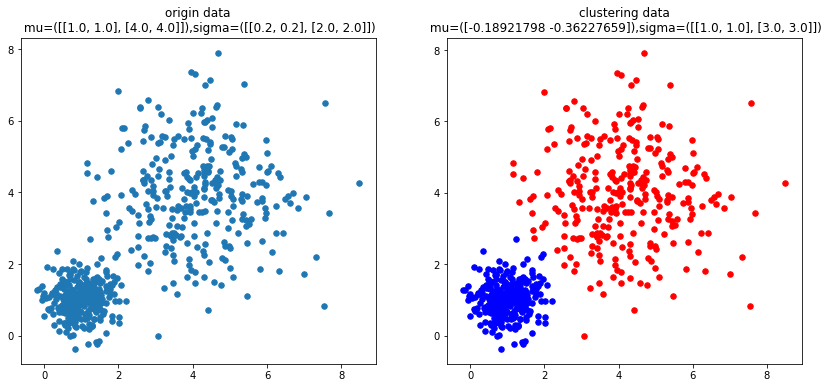

In [4]:
# 预测
alpha_, mu_, sigma_ = g.get_params()
k = len(alpha_)
prob = []
for i in range(k):
    cov_matrix = np.diag(sigma_[i])
    norm = multivariate_normal(mu_[i], cov_matrix)
    prob.append(norm.pdf(data))
prob = np.array(prob)
k1 = np.where(prob[0] >= prob[1])[0]
k2 = np.where(prob[0] < prob[1])[0]


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(data[:,0], data[:,1],s=30)
plt.title('origin data\n mu=({}),sigma=({})'.format(mu_true,sigma_true))

plt.subplot(1,2,2)
plt.scatter(data[k1,0], data[k1,1],s=30,c='b')
plt.scatter(data[k2,0], data[k2,1],s=30,c='r')
plt.title('clustering data\n mu=({}),sigma=({})'.format(mu[0],sigma))
plt.show()